### 1.导入需要的库

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score

### 2.导入波士顿数据集

In [4]:
dataset = load_boston()

dataset.data.shape

(506, 13)

In [5]:
x_full, y_full = dataset.data, dataset.target
n_samples = x_full.shape[0]
n_features = x_full.shape[1]

### 3. 为完整数据集放入缺失值

In [7]:
#假设50%的数据缺失
rng = np.random.RandomState(0)
missing_rate = 0.5
n_missing_samples = int(np.floor(n_samples * n_features * missing_rate))

3289

In [8]:
missing_features = rng.randint(0, n_features, n_missing_samples)
missing_samples = rng.randint(0, n_samples, n_missing_samples)

x_missing = x_full.copy()
y_missing = y_full.copy()

x_missing[missing_samples, missing_features] = np.nan

x_missing = pd.DataFrame(x_missing)

### 4. 使用0和均值填补缺失值

In [9]:
#均值填补
imp_mean = SimpleImputer(missing_values=np.nan, strategy="mean")
x_missing_mean = imp_mean.fit_transform(x_missing)

#0填补
imp_0 = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0)
x_missing_0 = imp_0.fit_transform(x_missing)

### 5. 使用随机森林填补缺失值

In [13]:
#利用其他未缺失值预测缺失值，若都有残缺则先0填充
x_missing_reg = x_missing.copy()
sortindex = np.argsort(x_missing_reg.isnull().sum(axis=0)).values

for i in sortindex:
    #构建我们的新特征矩阵和新标签
    df = x_missing_reg
    fillc = df.iloc[:,i]
    df = pd.concat([df.iloc[:,df.columns != i],pd.DataFrame(y_full)],axis=1)
    
    #在新特征矩阵中，对含有缺失值的列，进行0的填补
    df_0 = SimpleImputer(missing_values=np.nan,
                        strategy="constant",fill_value=0).fit_transform(df)
    
    #找出训练集测试集
    ytrain = fillc[fillc.notnull()]
    ytest = fillc[fillc.isnull()]
    xtrain = df_0[ytrain.index,:]
    xtest = df_0[ytest.index,:]
    
    #用随机森林回归填补缺失值
    rfc = RandomForestRegressor(n_estimators=100)
    rfc = rfc.fit(xtrain, ytrain)
    ypredict = rfc.predict(xtest)
    
    #将预测好的值返回原始矩阵
    x_missing_reg.loc[x_missing_reg.iloc[:,i].isnull(),i] = ypredict

### 6. 对填补好的数据进行建模

In [16]:
#建模，取得mse结果

x = [x_full,x_missing_mean,x_missing_0,x_missing_reg]

mse = []
std = []
for x in x:
    estimator = RandomForestRegressor(random_state=0, n_estimators=100)
    scores = cross_val_score(estimator,x,y_full,scoring='neg_mean_squared_error',
                            cv=5).mean()
    mse.append(scores * -1)
    

### 7. 用所得结果画出条形图

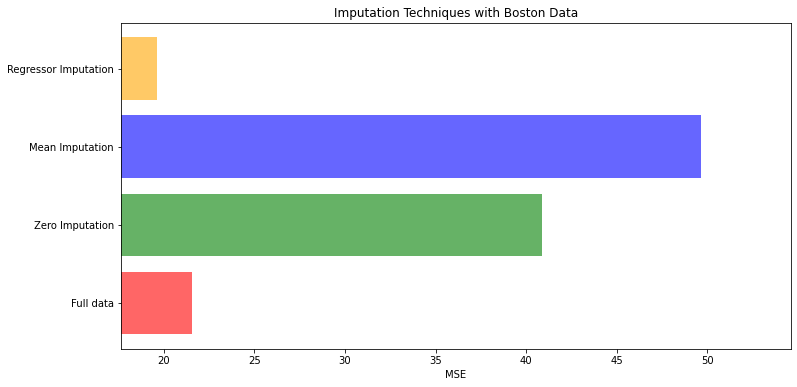

In [21]:
x_labels = ['Full data',
           'Zero Imputation',
           'Mean Imputation',
           'Regressor Imputation']
colors = ['r','g','b','orange']

plt.figure(figsize=(12,6))
ax = plt.subplot(111)
for i in  np.arange(len(mse)):\
    ax.barh(i, mse[i],color=colors[i],alpha=0.6,align='center')
ax.set_title("Imputation Techniques with Boston Data")
ax.set_xlim(left=np.min(mse)*0.9,
           right=np.max(mse)*1.1)
ax.set_yticks(np.arange(len(mse)))
ax.set_xlabel('MSE')
ax.set_yticklabels(x_labels)
plt.show()